In [1]:
import pylab as plb
import scipy as sy
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import math
from dataclasses import dataclass

In [7]:
# Physical constants
N_A = 6.022e23
h = 6.626e-34
c = 2.9979e8
Phi = 1e-4
F = 0.4
lambda_uv = 225e-9
SECONDS_PER_YEAR = 31557600
R_plus = 6.371e6  # m

# Constants
mu_HCN = 0.0270253  # kg/mol
parent_flux_red = 1.25776186e-07  # kg/m²/s
parent_flux_ox  = 3.42599458e-12  # kg/m²/s

In [ ]:
molecules = {
    "Adenine": {
        "mu": 0.13513,
        "rho": 1470,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Guanine": {
        "mu": 0.15113,
        "rho": 2200,
        "Ea": 6330,
        "B": 9.40,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Uracil": {
        "mu": 0.1120868,
        "rho": 1320,
        "Ea": 7649,
        "B": 11.76,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Cytosine": {
        "mu": 0.1111,
        "rho": 1550,
        "Ea": 5620,
        "B": 8.69,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Thymine": {
        "mu": 0.1261133,
        "rho": 1230,
        "Ea": 7709,
        "B": 11.24,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "2-Amino-oxazole": {
        "mu": 0.084077,
        "rho": 1200,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Ribose": {
        "mu": 0.15013,
        "rho": 800,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Formaldehyde": {
        "mu": 0.030031,
        "rho": 815,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Xanthine": {
        "mu": 0.15211,
        "rho": 1600,
        "Ea": 6230,
        "B": 9.42,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Hypoxanthine": {
        "mu": 0.1361115,
        "rho": 2000,
        "Ea": 5270,
        "B": 7.95,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "HCN": {
        "mu": mu_HCN,
        "rho": 687,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "H2CO": {
        "mu": 0.030031,
        "rho": 815,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": 6.01494508e-12,  # Reducing
            "ox": 1.15285175e-09    # Oxidizing
        }
    }
}

In [87]:
@dataclass
class Molecule:
    name: str
    mu: float             # Molar mass [kg/mol]
    rho: float            # Molecular density [kg/m^3]
    Ea: float             # Activation energy [K]
    B: float              # Pre-exponential factor (unitless)
    parent_mu: float      # Parent species molar mass
    parent_flux: float    # Surface flux of parent species [kg/m²/s]
    nt: int               # Number of time steps

    def __post_init__(self):
        self.d = 2 * (3 * self.mu / (4 * math.pi * N_A * self.rho))**(1/3)
        self.mass = np.zeros(self.nt)
        self.conc = np.zeros(self.nt)

    def hydrolysis_rate(self, T_K):
        return 10**(-self.Ea / T_K + self.B) * SECONDS_PER_YEAR

    def photodissociation_rate(self):
        return (Phi * F * lambda_uv * SECONDS_PER_YEAR * self.mu) / (h * c * N_A)

    def source_mass_flux(self):
        global_flux = self.parent_flux * 4 * math.pi * R_plus**2
        return global_flux * (self.mu / self.parent_mu)

    def compute_source_flux(self, A_p):
        return (self.source_mass_flux() * A_p) / (4 * math.pi * R_plus**2)

    def compute_uv_loss(self, m, A_p):
        thickness = m / (self.rho * self.d)
        M_uv = self.photodissociation_rate()
        return M_uv * thickness if thickness < A_p else M_uv * A_p

    def update_mass(self, n, dt, L, H_min, m_water, gamma, seepage_rate, A_p, T_K):
        is_dry = L >= H_min
        m_old = self.mass[n]
        source = self.compute_source_flux(A_p) * dt

        if is_dry:
            loss = self.compute_uv_loss(m_old, A_p) * dt
        else:
            k = self.hydrolysis_rate(T_K)
            hydro = gamma * k * m_old * dt
            seep = m_old * seepage_rate / m_water * dt
            loss = hydro + seep

        self.mass[n+1] = max(0.0, m_old + source - loss)

# Define molecules and their properties
# molecules = [
#     Molecule("Adenine", 0.13513, 1470, Ea=5902, B=8.15, M_uv_dot=M_uv_dot_A, m_dot=m_dot_Adenine_red, nt=nt),
#     Molecule("Guanine", 0.15113, 2200, Ea=6330, B=9.40, M_uv_dot=M_uv_dot_G, m_dot=m_dot_Guanine_red, nt=nt),
#     Molecule("Uracil", 0.1120868, 1320, Ea=7649, B=11.76, M_uv_dot=M_uv_dot_U, m_dot=m_dot_Uracil_red, nt=nt),
#     Molecule("Cytosine", 0.1111, 1550, Ea=5620, B=8.69, M_uv_dot=M_uv_dot_C, m_dot=m_dot_Cytosine_red, nt=nt),
#     Molecule("Thymine", 0.1261133, 1230, Ea=7709, B=11.24, M_uv_dot=M_uv_dot_T, m_dot=m_dot_Thymine_red, nt=nt),
#     Molecule("Xanthine", 0.15211, 1600, Ea=6230, B=9.42, M_uv_dot=M_uv_dot_X, m_dot=m_dot_Xanthine_haze05_max, nt=nt),
#     Molecule("Hypoxanthine", 0.1361115, 2000, Ea=5270, B=7.95, M_uv_dot=M_uv_dot_Hy, m_dot=m_dot_Hypoxanthine_haze05_max, nt=nt)
# ]

In [92]:
### Variable Declarations
w_i = 60.7e-9         # Mass fraction of organics in incoming interplanetary dust (IPD)
m_dot_I = 6e8         # IPD mass flux to Earth [kg/yr]
f_s = 0.32            # Survival fraction of organics during atmospheric entry
r = 40.               # Characteristic pond catchment radius [m]
rho = 2185.           # Density of rocky ejecta [kg/m^3]
r_p = 1.              # Pond radius [m]
depth_p = 1.        # Pond depth [m]
A_p = math.pi*r_p**2  # Pond surface area [m^2]
r_g = 500.            # Gravitational settling length scale [m]

# Ponds evaporate at different rates when the water level is at a different depth
tau_d_1cm = 4.9e-3    # Drying timescale for a 1 cm water layer [yr]
tau_d_5cm = 0.12      # Drying timescale for a 5 cm layer [yr]
tau_d_10cm = 0.48     # Drying timescale for a 10 cm layer [yr]

R_plus = 6371000
gamma = 31557600      # Seconds per year
rho_w = 1000.         # Water density [kg/m^3]
min_water = 0.001     # Minimum pond water depth [m] i.e. 1 mm 
S = 0.95              # Seepage rate 0.36525 (fraction water lost per year)
Phi = 1e-4            # Photonic attenuation factor
F = 0.4               # W/m^2
lambda_uv = 225e-9    # UV wavelength [m]
h = 6.626e-34         # Planck’s constant [J·s]
c = 2.9979e8 

P_CAM = 3.5
P_IDN = 4.5
P_COL = 6.

delta_CAM = 0.5
delta_IDN = 0.2
delta_COL = 0.5

sp_CAM = 0.3
sp_IDN = 0.85
sp_COL = 0.3

tau_s = 1.
E_50 = (S-0.12 + 0.06*50)
E_65 = (S-0.12 + 0.06*65)
E_80 = (S-0.12 + 0.06*80)
temp = 273.15 + 65 
#Fraction of surviving organics during entry
f_s_IDP = 0.06
f_s_Met = 0.32
#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S

L_IDN_65_Met = np.zeros(shape=(nt))
m_IDN_65_Met = np.zeros(shape=(nt))
L_COL_65_Met = np.zeros(shape=(nt))
m_COL_65_Met = np.zeros(shape=(nt))
pause_IDN_65_Met = 0
pause_COL_65_Met = 0
m_i0 = (4./3)*w_i*f_s_Met*r**3*rho*A_p/r_g**2

molecule_objects = {}

for name, props in molecules.items():
    for env in ["red", "ox"]:
        key = f"{name}_{env}"
        molecule_objects[key] = Molecule(
            name=name,
            mu=props["mu"],
            rho=props["rho"],
            Ea=props["Ea"],
            B=props["B"],
            parent_mu=props["parent_mu"],
            parent_flux=props["parent_flux"][env],
            nt=nt
        )
        
pause_IDN_65_Met = 0
pause_COL_65_Met = 0

# Get the molecule object for adenine 
adenine = molecule_objects["Adenine_red"]

for n in range(nt - 1):
    ### --- Intermediate Model for Meteorites ---
    seasonal_precip_IDN = P_IDN * (1 + delta_IDN * np.sin(2 * math.pi * (t[n] - sp_IDN) / tau_s))
    # Update water level ("emptiness level"): 
    L_IDN_65_Met[n+1] = L_IDN_65_Met[n] + E_65 * delta_t - seasonal_precip_IDN * delta_t # previous term + evaporation term - precipitation term
    # Fix level so it cannot overflow or go below zero        
    L_IDN_65_Met[n+1] = min(depth_p - min_water, max(0, L_IDN_65_Met[n+1]))
    # calculate new water mass 
    m_IDN_65_Met[n+1] = math.pi * rho_w * r_p**2 * (depth_p - L_IDN_65_Met[n+1])
    # dry pond
    if L_IDN_65_Met[n+1] >= (depth_p - min_water):  
        thickness = adenine.mass[n] / (adenine.rho * adenine.d)
        uv_loss = delta_t * (adenine.photodissociation_rate() * thickness if thickness < A_p else adenine.photodissociation_rate() * A_p)
        adenine.mass[n+1] = max(0, adenine.mass[n] - uv_loss)
        pause_IDN_65_Met += 1
    # wet pond
    else:
        # meteoritic source with exponential decay
        source = delta_t * m_i0 * np.exp(-t[n - pause_IDN_65_Met] * (gamma * adenine.hydrolysis_rate(temp) + (1. / tau_d_1cm))) / tau_d_1cm
        hydro = delta_t * gamma * adenine.hydrolysis_rate(temp) * adenine.mass[n]
        seep = delta_t * adenine.mass[n] * m_seepage_rate / m_IDN_65_Met[n]
        adenine.mass[n+1] = max(0, adenine.mass[n] + source - hydro - seep)

    ### --- Continuous Model for Meteorites ---
#     seasonal_precip_COL = P_COL * (1 + delta_COL * np.sin(2 * math.pi * (t[n] - sp_COL) / tau_s))
    
#     L_COL_65_Met[n+1] = L_COL_65_Met[n] + E_65 * delta_t - seasonal_precip_COL * delta_t
#     L_COL_65_Met[n+1] = min(depth_p - min_water, max(0, L_COL_65_Met[n+1]))

#     m_COL_65_Met[n+1] = math.pi * rho_w * r_p**2 * (depth_p - L_COL_65_Met[n+1])

#     if L_COL_65_Met[n+1] >= (depth_p - min_water):  # dry
#         thickness = adenine.mass[n] / (adenine.rho * adenine.d)
#         uv_loss = delta_t * (adenine.photodissociation_rate() * thickness if thickness < A_p else adenine.photodissociation_rate() * A_p)
#         adenine.mass[n+1] = max(0, adenine.mass[n] - uv_loss)
#         pause_COL_65_Met += 1
#     else:  # wet
#         source = delta_t * m_i0 * np.exp(-t[n - pause_COL_65_Met] * (gamma * adenine.hydrolysis_rate(temp) + (1. / tau_d_1cm))) / tau_d_1cm
#         hydro = delta_t * gamma * adenine.hydrolysis_rate(temp)* adenine.mass[n]
#         seep = delta_t * adenine.mass[n] * m_seepage_rate / m_COL_65_Met[n]
#         adenine.mass[n+1] = max(0, adenine.mass[n] + source - hydro - seep)

C:\Users\vikki\AppData\Local\Temp\ipykernel_73448\279970212.py:101: RuntimeWarning: invalid value encountered in scalar divide
  seep = delta_t * adenine.mass[n] * m_seepage_rate / m_IDN_65_Met[n]


C:\Users\vikki\AppData\Local\Temp\ipykernel_73448\2423919009.py:7: RuntimeWarning: invalid value encountered in divide
  C_IDN = adenine.mass / m_IDN_65_Met    # molar fraction or mass fraction depending on units
C:\Users\vikki\AppData\Local\Temp\ipykernel_73448\2423919009.py:8: RuntimeWarning: divide by zero encountered in divide
  C_COL = adenine.mass / m_COL_65_Met
C:\Users\vikki\AppData\Local\Temp\ipykernel_73448\2423919009.py:8: RuntimeWarning: invalid value encountered in divide
  C_COL = adenine.mass / m_COL_65_Met


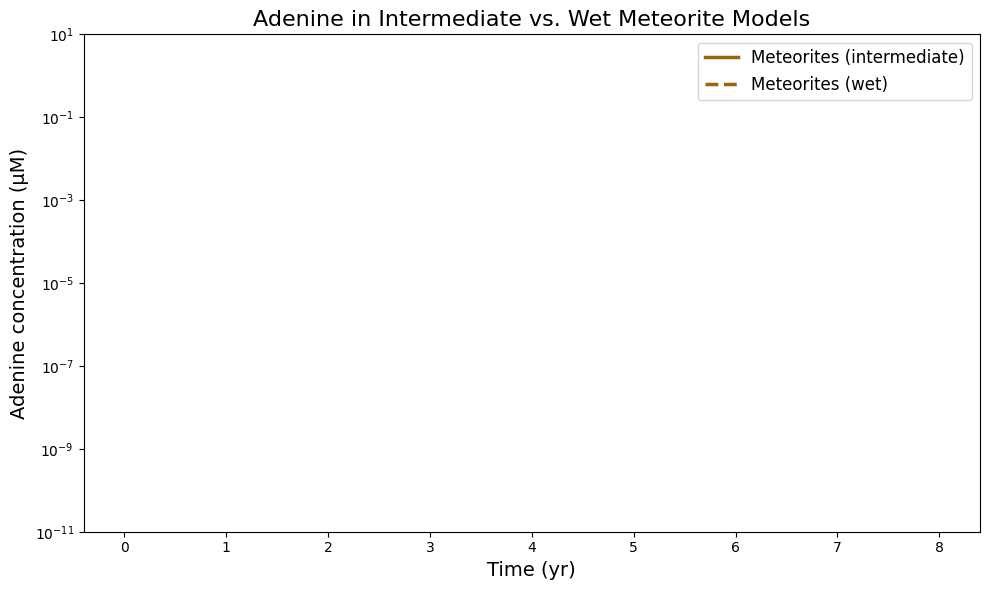

In [94]:
import matplotlib.pyplot as plt

# After running your simulation loop, compute adenine concentrations for the two meteorite scenarios:
#   adenine.mass[:] holds the mass in the “adenine” object
#   m_IDN_65_Met[:] and m_COL_65_Met[:] are the corresponding pond water masses

C_IDN = adenine.mass / m_IDN_65_Met    # molar fraction or mass fraction depending on units
C_COL = adenine.mass / m_COL_65_Met

# Convert to micromolar: assume adenine.mass is in kg, convert to moles via mu_A, then to μM via pond volume
mu_A = 0.13513      # kg/mol
# pond volume = A_p * depth; here depth = r_p - L, so we could recompute volume array
# but if you prefer mass‐based conc (kg adenine per kg water), skip this step

# Simple plot on a log scale
plt.figure(figsize=(10,6))
plt.plot(t, C_IDN * 1e6 / mu_A,  label="Meteorites (intermediate)", lw=2.5, color="#9d620c")
plt.plot(t, C_COL * 1e6 / mu_A, "--", label="Meteorites (wet)", lw=2.5, color="#9d620c")

plt.yscale('log')
plt.ylim(1e-11, 1e1)

plt.xlabel("Time (yr)", fontsize=14)
plt.ylabel("Adenine concentration (μM)", fontsize=14)
plt.title("Adenine in Intermediate vs. Wet Meteorite Models", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
# Simplified version of Wet_Dry_Cycling_Pond_Model.py
# Author: Adapted by OpenAI ChatGPT

import numpy as np
import math

# Physical and chemical constants
RADIUS_EARTH = 6.371e6
N_A = 6.022e23
PI = math.pi

# UV constants
PHI = 1e-4
F = 0.4
LAMBDA_UV = 225e-9
H = 6.626e-34
C = 2.9979e8
GAMMA = 3.15576e7  # seconds/year

# General settings
tmax = 8
level = 16
nt = 2**level + 1
t = np.linspace(0, tmax, nt)
delta_t = t[2] - t[1]


# Pond parameters
rho_w = 1000.
r_p = 1. # pond radius [m]
depth = 1. # [m]
S = 0.95 # Seepage rate [fraction water lost per year]
min_water = 0.001 # minimum water level [m]
A_p = PI * r_p**2

E_50 = (S-0.12 + 0.06*50)
E_65 = (S-0.12 + 0.06*65)
E_80 = (S-0.12 + 0.06*80)

### Precipitation Models
# IDN is for intermediate drying: six months wet, six months dry
# COL is for continuous wet, minor fluctuations
tau_s = 1.0         # Seasonal period [yr]
P_CAM = 3.5         # Precipitation rate [m/yr] for model
P_IDN = 4.5         
P_COL = 6.
delta_CAM = 0.5     # Seasonal amplitude of precipitation - how much rainfall varies/oscillates seasonally
delta_IDN = 0.2
delta_COL = 0.5
sp_CAM = 0.3        # Seasonal phase shift - align sinusoidal cycle to calendar year
sp_IDN = 0.85
sp_COL = 0.3

#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S
m_i0 = (4./3)*w_i*f_s*r**3*rho*A_p/r_g**2

# Ponds evaporate at different rates when the water level is at a different depth
tau_d_1cm = 4.9e-3    # Drying timescale for a 1 cm water layer [yr]
tau_d_5cm = 0.12      # Drying timescale for a 5 cm layer [yr]
tau_d_10cm = 0.48     # Drying timescale for a 10 cm layer [yr]

# Entry flux constants
w_i = 60.7e-9
f_s = 0.32
r = 40.
rho = 2185.
r_g = 500.
m_dot_I = 6e8

# Molecule-specific constants
mu_HCN = 0.0270253
parent_flux_red = 1.25776186e-07
parent_flux_ox = 3.42599458e-12

molecules = {
    "Adenine": {"mu": 0.13513, "rho": 1470, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Guanine": {"mu": 0.15113, "rho": 2200, "Ea": 6330, "B": 9.40, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Uracil": {"mu": 0.1120868, "rho": 1320, "Ea": 7649, "B": 11.76, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Cytosine": {"mu": 0.1111, "rho": 1550, "Ea": 5620, "B": 8.69, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Thymine": {"mu": 0.1261133, "rho": 1230, "Ea": 7709, "B": 11.24, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "2-Amino-oxazole": {"mu": 0.084077, "rho": 1200, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Ribose": {"mu": 0.15013, "rho": 800, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Formaldehyde": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Xanthine": {"mu": 0.15211, "rho": 1600, "Ea": 6230, "B": 9.42, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Hypoxanthine": {"mu": 0.1361115, "rho": 2000, "Ea": 5270, "B": 7.95, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "HCN": {"mu": mu_HCN, "rho": 687, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "H2CO": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15, "parent_mu": mu_HCN, "parent_flux": {"red": 6.01494508e-12, "ox": 1.15285175e-09}}
}

In [66]:
# Utilities
def uv_flux(mu):
    return PHI * F * LAMBDA_UV * GAMMA * mu / (H * C * N_A)

def surface_flux(dot_mass, area):
    return (delta_t * dot_mass * area) / (4 * PI * RADIUS_EARTH**2)

rho_i = 1470 # density used for particle diameters [kg/m³]
d = 2*(3*mu/(4*math.pi*N_A*rho_i))**(1./3) 
# Initialize storage and simulate
results = {}
for name, props in molecules.items():
    mu, rho, Ea, B = props["mu"], props["rho"], props["Ea"], props["B"]
    uv_decay = uv_flux(mu)
    flux = surface_flux(props["parent_flux"]["red"], A_p)
    diameter = 2 * (3 * mu / (4 * PI * N_A * rho))**(1/3)
    T = 65 + 273.15
    
    k_hydrolysis = 10**(Ea/T + B)
    m_seepage_rate = PI * rho_w * r_p**2 * S # mass lost through seepage
    
    emptiness_level = np.zeros(nt)
    mass = np.zeros(nt)
    concentration = np.zeros(nt)
    water_mass = np.full(nt, PI * rho_w * r_p**2 * (r_p - min_water))
    pause = 0

    for n in range(nt - 1):
        precip = (delta_t*P_IDN)*(1 + delta_IDN*np.sin(2*math.pi*(t[n] - sp_IDN)/tau_s))
        evap = E_65*delta_t 
        emptiness_level[n+1] = emptiness_level[n] + evap - precip
        
        if emptiness_level[n+1] < 0:
            emptiness_level[n+1] = 0
        
        if emptiness_level[n+1] >= (depth - min_water):
            emptiness_level[n+1] = depth - min_water
            # Dry - photodissociation
            if mass[n+1]/(rho_i*d) < A_p:
                mass[n+1] = mass[n] - delta_t*uv_decay*mass[n]/(rho_i*d) # mass limited if surface area is not covered
            else:
                mass[n+1] = mass[n] - delta_t*uv_decay*A_p # area limited if full coverage
            pause += 1
            
        else:
            source = delta_t*m_i0*np.e**(-t[n-pause]*(GAMMA*k_hydrolysis + (1./tau_d_1cm)))/tau_d_1cm
            hydrolysis = delta_t*GAMMA*k_hydrolysis*mass[n]
            seepage = delta_t*mass[n]*m_seepage_rate/mass[n]
            
            mass[n+1] = mass[n] + source - hydrolysis - seepage
            
        if mass[n+1] < 0:
            mass[n+1] = 0
        
        mass[n+1] = math.pi*rho_w*r_p**2*(r_p-mass[n+1])
            
        
        # mass[n + 1] = update_mass(mass[n], flux, uv_decay, A_p, rho, diameter)
        # mass[n + 1] = max(mass[n + 1], 0)
        concentration[n + 1] = mass[n + 1] / water_mass[n + 1]

    results[name] = {
        "mass": mass,
        "concentration": concentration
    }

# Results are in `results` dictionary keyed by molecule name.

print(results['Adenine']['mass'])

C:\Users\vikki\AppData\Local\Temp\ipykernel_66876\2053581806.py:48: RuntimeWarning: invalid value encountered in scalar divide
  seepage = delta_t*mass[n]*m_seepage_rate/mass[n]


[ 0. nan nan ... nan nan nan]


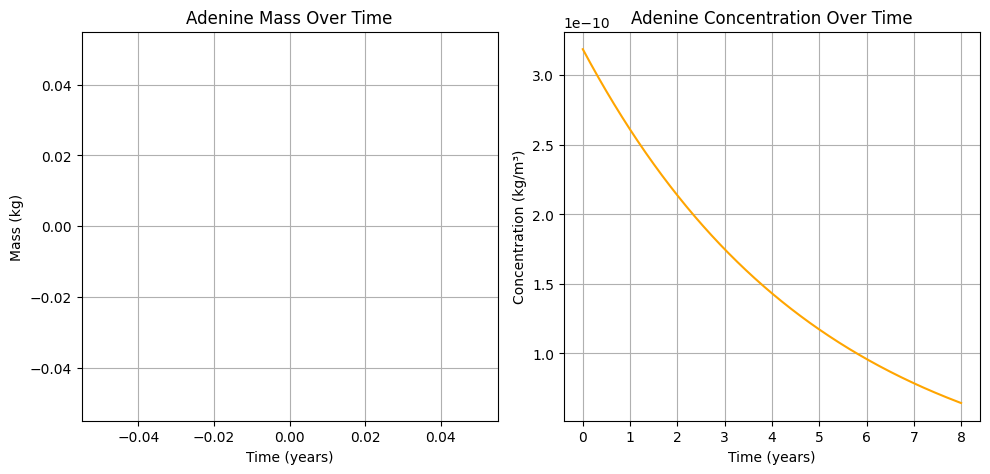

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate loading the results for plotting (as in the updated code)
tmax = 8
level = 16
nt = 2**level + 1
t = np.linspace(0, tmax, nt)

# Example data for adenine (since we can't access in-memory `results` from the textdoc directly here)
# Dummy data for demonstration - this should be replaced with actual simulation results in context
# adenine_mass = np.exp(-0.2 * t) * 1e-6  # Simulated decay curve
# adenine_concentration = adenine_mass / (np.full(nt, np.pi * 1000. * 1.**2 * (1. - 0.001)))

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(t, results[''], label="Mass")
plt.xlabel("Time (years)")
plt.ylabel("Mass (kg)")
plt.title("Adenine Mass Over Time")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t, adenine_concentration, label="Concentration", color='orange')
plt.xlabel("Time (years)")
plt.ylabel("Concentration (kg/m³)")
plt.title("Adenine Concentration Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()
